In [37]:
pip install torchmetrics

In [38]:
import torch
from torchmetrics import Accuracy
from sklearn.datasets import make_moons

In [39]:
#creating the dataset
samples = 1000
random_state = 42

X,y = make_moons(n_samples=samples, shuffle=True, random_state = random_state)

In [40]:
len(X), len(y)

(1000, 1000)

In [41]:
#transforming data into tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [56]:
#Splitting into train and test dataset
#1° method
split_value = int(0.8 * len(X))
X_train, y_train = X[:split_value], y[:split_value]
X_test, y_test = X[split_value :], y[split_value :]
len(X_train), len (X_test)

#2° method
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
len(X_train), len (y_train)



(800, 800)

In [43]:
#creating a model
import torch
from torch import nn

#1. set up a device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

#2. building the class
class MoonClass(nn.Module):
  def __init__ (self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

my_model_0 = MoonClass().to(device)
my_model_0

MoonClass(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [44]:
#setting up loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=my_model_0.parameters(), lr = 0.1)

In [60]:
#Creating a training and testing loop

#for repetability
torch.manual_seed(42)

#setting the data to device, since the model is in the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

labels =torch.round(torch.sigmoid(my_model_0(X_train.to(device))))
print(labels.shape)

#creating the loops
epochs = 300

for epoch in range(epochs):
  my_model_0.train()

  #going from logits to prediction probabilities to prediction labels
  y_logits = my_model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))


  loss = loss_fn(y_logits, y_train)
  metrics_accuracy = Accuracy(task = 'multiclass', num_classes=2).to(device)
  accuracy = metrics_accuracy(y_pred, y_train.int())

  #optimizer zero grad
  optimizer.zero_grad()

  #loss backwards
  loss.backward()

  #optimizer step
  optimizer.step()

  #TESTING
  my_model_0.eval()
  with torch.inference_mode():

    #forward pass
    y_logits_test = my_model_0(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits_test))

    #loss and accuracy
    loss_test = loss_fn(y_logits_test, y_test)
    accu_test = metrics_accuracy(y_pred_test, y_test.int())

  if epoch % 10 == 0:
    print(f"Epoch {epoch}, the loss is {loss}, the accuracy is {accuracy}, the loss is {loss_test}, the accuracy is {accu_test}")









torch.Size([800, 1])
Epoch 0, the loss is 0.10180681198835373, the accuracy is 0.9612500071525574, the loss is 0.0991138145327568, the accuracy is 0.9750000238418579
Epoch 10, the loss is 0.09746033698320389, the accuracy is 0.9637500047683716, the loss is 0.09476100653409958, the accuracy is 0.9750000238418579
Epoch 20, the loss is 0.09320728480815887, the accuracy is 0.9674999713897705, the loss is 0.09051203727722168, the accuracy is 0.9750000238418579
Epoch 30, the loss is 0.08906885981559753, the accuracy is 0.9700000286102295, the loss is 0.08636429160833359, the accuracy is 0.9800000190734863
Epoch 40, the loss is 0.08505108207464218, the accuracy is 0.9725000262260437, the loss is 0.08234654366970062, the accuracy is 0.9800000190734863
Epoch 50, the loss is 0.08116142451763153, the accuracy is 0.9762499928474426, the loss is 0.0784774050116539, the accuracy is 0.9800000190734863
Epoch 60, the loss is 0.07741454988718033, the accuracy is 0.9787499904632568, the loss is 0.0747231

In [ ]:
  with torch.inference_mode():

    #forward pass
    y_logits_test = my_model_0(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits_test))

In [61]:
import requests
from pathlib import Path
#downlaod helper functios from pytorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:  #we are creating a file into which we write the content of the request variable
   f.write(request.content)

Download helper_functions.py


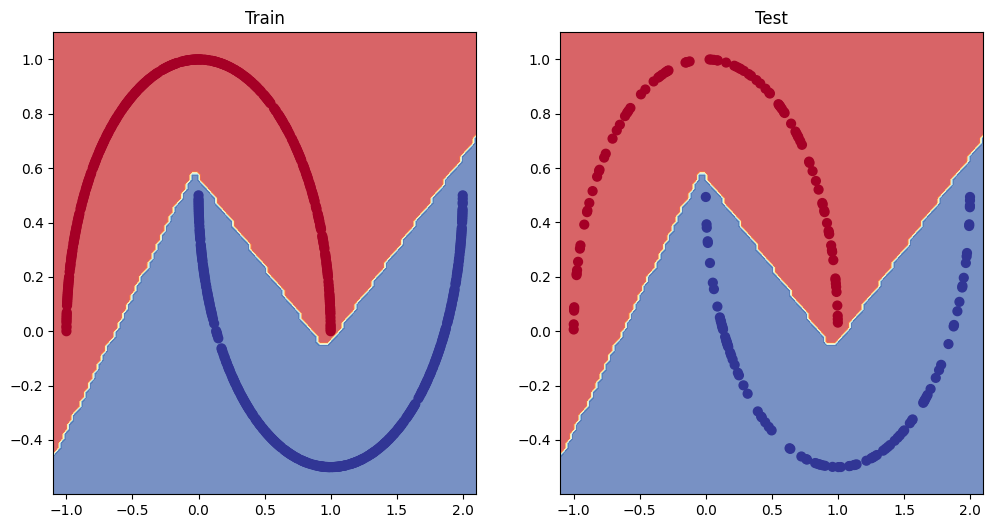

In [64]:
from helper_functions import plot_predictions, plot_decision_boundary
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(my_model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(my_model_0, X_test, y_test)